In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

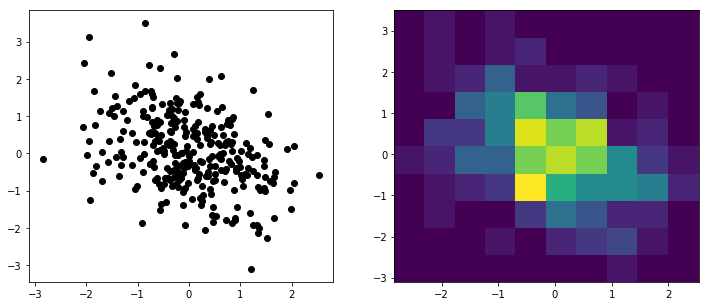

In [2]:
N = 300
n_dim = 2
cov = np.array([[1.0,-0.4],[-0.4,1.0]])
samples = stats.multivariate_normal(cov=cov).rvs(size=N)


fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].scatter(samples[:,0], samples[:,1], color="k")
ax[1].hist2d(samples[:,0], samples[:,1])
plt.show()

In [3]:
n_up = 10000
n_interp = 100

# SMOTE

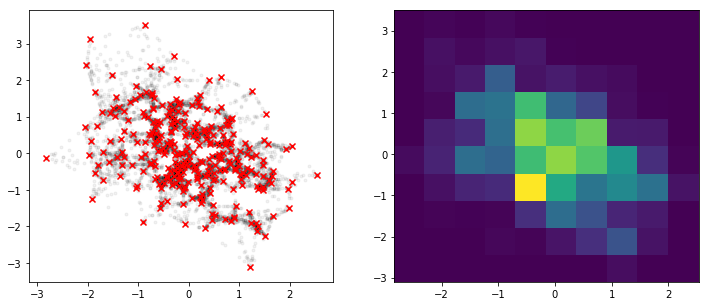

In [4]:
from sklearn.neighbors import NearestNeighbors

n_kNN = 10

neighbors = NearestNeighbors(n_neighbors=n_kNN).fit(samples)
dist, idx = neighbors.kneighbors(samples)

random_sample_index = np.random.randint(0, N, n_up)
random_kNN = np.random.randint(0, n_kNN, n_up)

random_samples = samples[random_sample_index]
random_neighbors = samples[idx[random_sample_index, random_kNN]]
random_weights = np.random.uniform(0, 1, n_up)

new_samples = (random_samples.T*random_weights + random_neighbors.T*(1-random_weights)).T


fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].scatter(new_samples[:,0], new_samples[:,1], marker=".", color="k", alpha=0.05)
ax[0].scatter(samples[:,0], samples[:,1], marker="x", color="r")
ax[1].hist2d(new_samples[:,0], new_samples[:,1])
plt.show()

# Random Walk

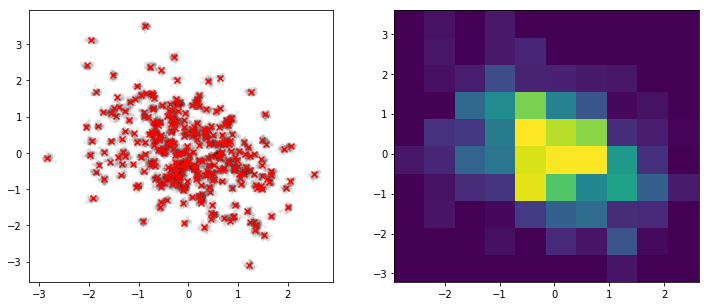

In [5]:
std = np.std(samples, axis=0)

random_sample_index = np.random.randint(0, N, n_up)

random_samples = samples[random_sample_index]
random_weights = np.random.normal(0, 1, n_up*n_dim).reshape(n_up, n_dim)

new_samples = random_samples + random_weights*std/np.sqrt(N)

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].scatter(new_samples[:,0], new_samples[:,1], marker=".", color="k", alpha=0.05)
ax[0].scatter(samples[:,0], samples[:,1], marker="x", color="r")
ax[1].hist2d(new_samples[:,0], new_samples[:,1])
plt.show()

# Kernel Density Estimate

In [6]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.covariance import EmpiricalCovariance

In [7]:
def KDE_sklearn(x, x_interp, bandwidth, **kwargs):
    """
    Generate a 1D kernel density estimate of a data array
    
    Parameters
    ----------
    x : array-like
        data samples
    x_interp : array-like
        data values for interpolation of KDE PDF
    bandwidth : float
        fixed value for KDE bandwidth
        
    Returns
    -------
    pdf : array-like
        PDF values evaluated at x_interp
    """
    kde = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde.fit(x[:, np.newaxis])
    
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde.score_samples(x_interp[:, np.newaxis])
    return np.exp(log_pdf)

In [8]:
def get_bw(samples, num_max=1000):
    """
    Use cross-validation to determine KDE bandwidth for a set of 1D data samples
    Iteratively performs first coarse then fine estimation   
    
    Parameters
    ----------
    samples : array-like
        1D data samples
    num_max : int (default=1000)
        maximum number of samples to use during estimation
        
    Returns
    -------
    bw : float
        estimated bandwidth
    """
    N = len(samples)
    x = np.random.choice(samples, size=np.min([num_max,N]), replace=False)
    
    coarse_mesh = np.linspace((x.max()-x.min())/N, np.std(x), int(np.sqrt(N)))
    grid = GridSearchCV(KernelDensity(), {"bandwidth": coarse_mesh}, cv=5)
    grid.fit(x[:, None])
    
    fine_mesh = grid.best_params_["bandwidth"] + np.linspace(-1,1,int(np.sqrt(N)))*(coarse_mesh[1]-coarse_mesh[0])
    grid = GridSearchCV(KernelDensity(), {"bandwidth": fine_mesh}, cv=5)
    grid.fit(x[:, None])

    return grid.best_params_["bandwidth"]

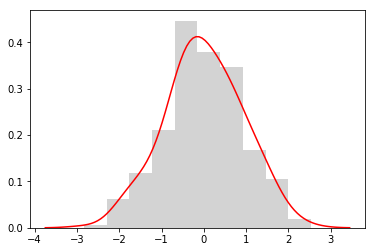

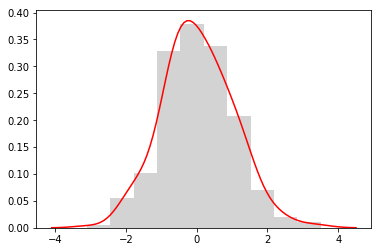

In [9]:
bandwidths = []
interp_grids = []

for i in range(n_dim):
    x = samples[:,i]
    bw = get_bw(x)    
    x_interp = np.linspace(x.min()-np.std(x), x.max()+np.std(x), n_interp)
    

    # save bandwidths and interpolation grids
    bandwidths.append(bw)
    interp_grids.append(x_interp)

    # plot 1D histogram
    pdf = KDE_sklearn(x, x_interp, bw)

    plt.figure()
    plt.hist(x, color="lightgrey", density=True)
    plt.plot(x_interp, pdf, "r")
    plt.show()
    
bandwidths = np.array(bandwidths)
interp_grids = np.array(interp_grids)

In [10]:
def generate_synthetic_samples(samples, bandwidths, n_up):
    """
    Use PDF Over-Sampling (PDFOS - Gao+ 2014) to generate synthetic samples
    
    Parameters
    ----------
    samples : ndarray, (N x M)
        array of data samples arranged N_samples, M_parameters
    bandwitdhs : array-like, (M)
        pre-estimated KDE bandwidths for each of M parameters
    n_up : int
        number of upsampled synthetic data points to generate
        
    Returns
    -------
    new_samples : ndarray
        array containing synthetic samples
    """
    # compute empirical covariance matrix and lower Cholesky decomposition
    emp_cov = EmpiricalCovariance().fit(samples).covariance_
    L = np.linalg.cholesky(emp_cov)

    # scale each parameter by precompputed bandwidths so they have similar variance
    samples_scaled = (samples - np.mean(samples, axis=0)) / bandwidths

    # calculate synthetic samples following PDFOS (Gao+ 2014)
    random_index = np.random.randint(0, N, n_up)
    random_samples = samples_scaled[random_index]
    random_weights = np.random.normal(0, 1, n_up*n_dim).reshape(n_up, n_dim)
    new_samples = random_samples + np.dot(L.T, random_weights.T).T

    # rescale each parameter to invert previous scaling
    return new_samples*bandwidths + np.mean(samples, axis=0)

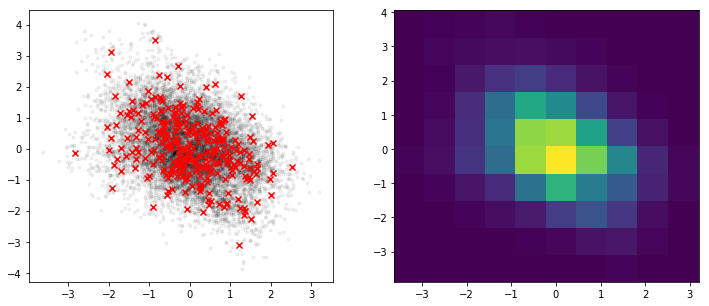

In [11]:
new_samples = generate_synthetic_samples(samples, bandwidths, n_up)

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].scatter(new_samples[:,0], new_samples[:,1], marker=".", color="k", alpha=0.05)
ax[0].scatter(samples[:,0], samples[:,1], marker="x", color="r")
ax[1].hist2d(new_samples[:,0], new_samples[:,1])
plt.show()